<a href="https://colab.research.google.com/github/mjmousavi97/Graph-Neural-Networks/blob/main/07_Vanilla_Neural_Networks/src/Node_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Project: Predicting Web Traffic with Node Regression

## 🧩 Overview
Goal: Predict the **log average monthly traffic (Dec 2018)** for each Wikipedia page using its **features** and **link structure**.

- **Nodes:** Wikipedia articles  
- **Edges:** Mutual hyperlinks between articles  
- **Node features:** Word presence in articles  
- **Target:** Continuous value (log traffic)

## 🧠 Task Type
**Node Regression** — predict a continuous value for each node (not a category).

## 📊 Dataset
**Wikipedia Network** (Rozemberczki et al., 2019 – GPL v3.0)  
Includes three subgraphs:

| Subgraph | Nodes | Edges |
|-----------|--------|--------|
| Chameleons | 2,277 | 31,421 |
| Crocodiles | 11,631 | 170,918 |
| Squirrels | 5,201 | 198,493 |

## 🎯 Objective
Learn to predict each page’s popularity using **Graph Neural Networks (GNNs)** based on node features and graph connections.


we will apply a GCN to predict this traffic on the chameleon dataset

In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.5 MB/s eta 0:00:00


In [4]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as transforms
from torch_geometric.utils import degree
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [5]:
dataset = WikipediaNetwork(root='data/wikipedia', name='chameleon')
transform = transforms.Compose(
    transforms.NormalizeFeatures()
)

data = dataset[0]

Processing...
Done!


In [6]:
print(f'dataset: {dataset}')
print(f'Number of Graphs: {len(dataset)}')
print(f'Number of Nodes: {data.x.shape[0]}')
print(f'Number of features per Node: {data.x.shape[1]}')
print(f'Number of Edges: {data.num_edges}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Labels: {data.y.unique().tolist()}')

dataset: WikipediaNetwork()
Number of Graphs: 1
Number of Nodes: 2277
Number of features per Node: 2325
Number of Edges: 36101
Number of classes: 5
Labels: [0, 1, 2, 3, 4]


In [7]:
from google.colab import files
uploaded = files.upload()

Saving musae_chameleon_target.csv to musae_chameleon_target.csv


In [8]:
df = pd.read_csv('/content/musae_chameleon_target.csv')

In [9]:
df.head()

,id,target
0,0,171
1,1,8089
2,2,8568
3,3,47178
4,4,3634


In [10]:
df.drop('id', axis=1, inplace=True)

In [11]:
df.tail()

,target
2272,31418
2273,2716
2274,99
2275,22898
2276,276


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  2277 non-null   int64
dtypes: int64(1)
memory usage: 17.9 KB


In [13]:
df.describe()

,target
count,2277.000000
mean,14128.469477
std,39638.662208
min,15.000000
25%,439.000000
50%,2003.000000
75%,11718.000000
max,508957.000000


In [14]:
target_values = np.log10(df['target'])

In [15]:
target_values

,target
0,2.232996
1,3.907895
2,3.932879
3,4.673740
4,3.560385
...,...
2272,4.497179
2273,3.433930
2274,1.995635
2275,4.359798


In [16]:
target_values.describe()

,target
count,2277.000000
mean,3.311093
std,0.928538
min,1.176091
25%,2.642465
50%,3.301681
75%,4.068853
max,5.706681


In [17]:
y = torch.tensor(target_values)
y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

In [18]:
data.y = y

In [19]:
dir(data)

['__abstractmethods__',
 '__annotations__',
 '__call__',
 '__cat_dim__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__inc__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_edge_attr_cls',
 '_edge_to_layout',
 '_edges_to_layout',
 '_find_parent',
 '_get_edge_index',
 '_get_tensor',
 '_get_tensor_size',
 '_multi_get_tensor',
 '_put_edge_index',
 '_put_tensor',
 '_remove_edge_index',
 '_remove_tensor',
 '_store',
 '_tensor_attr_cls',
 '_to_type',
 '_union',
 'apply',
 'apply_',
 'batch',
 'clone',
 'coalesce',
 'c

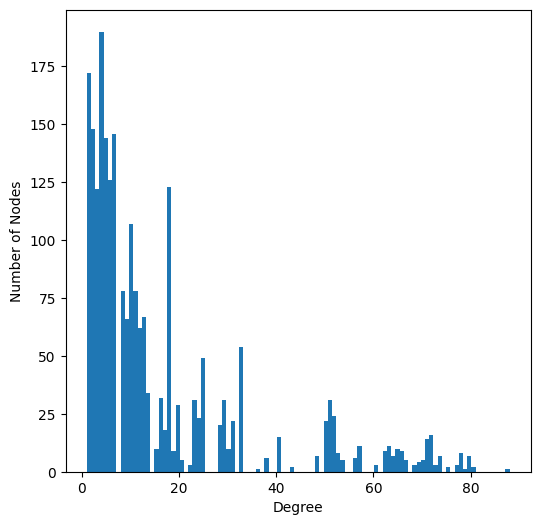

In [20]:
edges = data.edge_index
degrees = degree(edges[0], data.num_nodes)

# Plot histogram of degrees
plt.figure(figsize=(6, 6))
plt.hist(degrees.numpy(), bins=100)
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

## Most nodes have one or a few neighbors, but some of them act as “hubs” and can connect more than 80 nodes

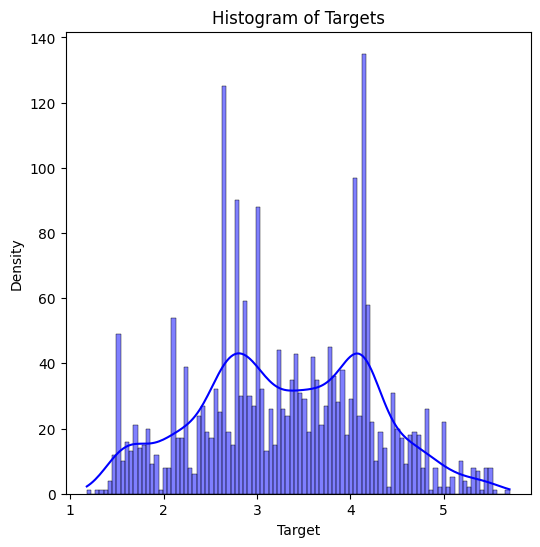

In [21]:
# Plot histogram of Targets
plt.figure(figsize=(6, 6))
sns.histplot(y, bins=100, kde=True, color='blue')
plt.title('Histogram of Targets')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

## This distribution is not exactly normal, but it is not exponential like the node degrees either. We can expect our model to perform well to predict these values.

In [38]:
data.train_mask = data.train_mask[:, 0]
data.val_mask   = data.val_mask[:, 0]
data.test_mask  = data.test_mask[:, 0]

In [43]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.num_hid1 = hidden_dim * 4
        self.num_hid2 = hidden_dim * 2
        self.num_out = output_dim

        self.gcn1 = GCNConv(input_dim, self.num_hid1)
        self.gcn2 = GCNConv(self.num_hid1, self.num_hid2)
        self.gcn3 = GCNConv(self.num_hid2, hidden_dim)

        self.linear = nn.Linear(hidden_dim, self.num_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = F.relu(h)
        h = torch.dropout(h, p=0.5, train=self.training)
        h = self.gcn2(h, edge_index)
        h = F.relu(h)
        h = torch.dropout(h, p=0.5, train=self.training)
        h = self.gcn3(h, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.02, weight_decay=5e-4)
        criterion = nn.MSELoss()

        self.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out.squeeze() [data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()

            if epoch % 10 == 0:
                self.eval()
                val_loss = criterion(out.squeeze() [data.val_mask], data.y[data.val_mask].float())
                self.train()
                print(f'Epoch: {epoch}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze() [data.test_mask], data.y[data.test_mask].float())


In [44]:
gcn = GCN(input_dim=data.num_features, hidden_dim=128, output_dim=1)
print(gcn)

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [45]:
gcn.fit(data, epochs=200)

Epoch: 0, Loss: 11.96045970916748, Val Loss: 11.908658981323242
Epoch: 10, Loss: 11.882315635681152, Val Loss: 11.821950912475586
Epoch: 20, Loss: 11.546638488769531, Val Loss: 11.485143661499023
Epoch: 30, Loss: 10.798053741455078, Val Loss: 10.691272735595703
Epoch: 40, Loss: 7.994948863983154, Val Loss: 7.757018566131592
Epoch: 50, Loss: 4.346033573150635, Val Loss: 4.622379779815674
Epoch: 60, Loss: 2.457366704940796, Val Loss: 3.4687130451202393
Epoch: 70, Loss: 1.090439796447754, Val Loss: 1.5412671566009521
Epoch: 80, Loss: 0.6700500249862671, Val Loss: 0.7405081391334534
Epoch: 90, Loss: 0.5512582063674927, Val Loss: 0.780511736869812
Epoch: 100, Loss: 0.4934892952442169, Val Loss: 0.8191344141960144
Epoch: 110, Loss: 0.4559721052646637, Val Loss: 0.765816867351532
Epoch: 120, Loss: 0.40959984064102173, Val Loss: 0.7167178988456726
Epoch: 130, Loss: 0.38500696420669556, Val Loss: 0.7582072615623474
Epoch: 140, Loss: 0.3580136001110077, Val Loss: 0.7263102531433105
Epoch: 150, L

In [46]:
loss = gcn.test(data)
print(f'Test Loss: {loss.item()}')

Test Loss: 0.760856568813324


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [63]:
gcn.eval()
with torch.no_grad():
    out = gcn(data.x, data.edge_index)
    y_pred = out.squeeze()[data.test_mask].detach().numpy()
    y_true = data.y[data.test_mask].detach().numpy()

In [64]:
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MSE: 0.7608565145564481
MAE: 0.6638589711835242
RMSE: 0.8722708951675782


In [65]:
y_true.shape

(456,)

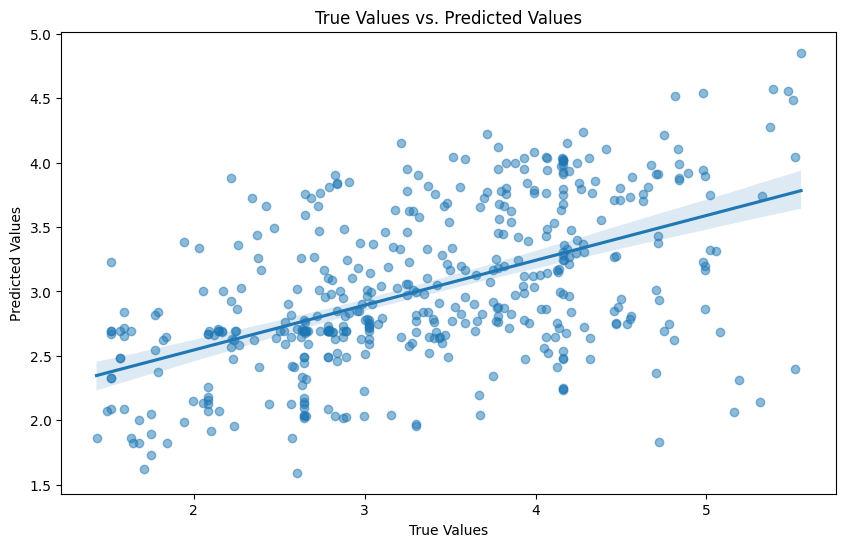

In [66]:
plt.figure(figsize=(10, 6))
sns.regplot(x=y_true, y=y_pred, scatter_kws={'alpha': 0.5})
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values')
plt.show()